# Non resampled Attention Unet


**In this notebook:**

* I will run a non resampled attention Unet 



## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [1]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/




### Import Dependencies

# System libraries

In [2]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
sys.setrecursionlimit(1000000000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml

import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils

import aneurysm_utils
from aneurysm_utils import training,preprocessing


/workspace/our-git-project/.venv-ml-in-mip/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
if "workspace" in os.getcwd():
    ROOT = "/workspace" # local 
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake" # Jupyter Lab


### Initialize Environment

In [4]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /workspace
 - Project folder: /workspace/our-git-project
 - Datasets folder: /workspace/our-git-project/datasets
 - Models folder: /workspace/our-git-project/models
 - Experiments folder: /workspace/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [5]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (1,1,1),
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation': False
}


### Load Meta Data

In [6]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/workspace/our-git-project/datasets/A001_orig....,/workspace/our-git-project/datasets/A001_masks...,/workspace/our-git-project/datasets/A001_vesse...,/workspace/our-git-project/datasets/A001_label...
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/workspace/our-git-project/datasets/A003_orig....,/workspace/our-git-project/datasets/A003_masks...,/workspace/our-git-project/datasets/A003_vesse...,/workspace/our-git-project/datasets/A003_label...
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/workspace/our-git-project/datasets/A005_orig....,/workspace/our-git-project/datasets/A005_masks...,/workspace/our-git-project/datasets/A005_vesse...,/workspace/our-git-project/datasets/A005_label...
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/workspace/our-git-project/datasets/A006_orig....,/workspace/our-git-project/datasets/A006_masks...,/workspace/our-git-project/datasets/A006_vesse...,/workspace/our-git-project/datasets/A006_label...
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/workspace/our-git-project/datasets/A008_orig....,/workspace/our-git-project/datasets/A008_masks...,/workspace/our-git-project/datasets/A008_vesse...,/workspace/our-git-project/datasets/A008_label...


### Load & Split MRI Data

In [7]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
#case_list = [ "A123", "A121", "A124"] # "A003","A005","A006","A008", "A010", "A012","A009", "A120",
#df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"]
)

mri_imgs_train, labels_train, train_participants = train_data
mri_imgs_test, labels_test, test_participants = test_data
mri_imgs_val, labels_val, val_participants= val_data

109
98
         Images
-----  --------
All         109
Train        87
Val          11
Test         11



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
from aneurysm_utils import preprocessing

most_commen_shape = preprocessing.check_mri_shapes(mri_imgs_train)

Most common:
(139, 139, 120):      75
(139, 139, 119):       5
(70, 70, 60):       5
(108, 108, 96):       2


## Transform & Preprocess Data

In [9]:
size = most_commen_shape  #(139, 139, 120)
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != size]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != size]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != size]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))

Most common:
(139, 139, 120):      75
(array([0., 1.], dtype=float32), array([2318414,     106]))


In [10]:
def patch_creater(image, patch_size):
    """
    Creates overlapping patches from  preprocessed image, the number of patches is fixed to certain value
    and the size can be changed as well
    ----------
    image: numpy.array
        image which will be sliced into patches
    patch_size: tuple of int
        size of the patch, equal in each direction
   
    Returns
    -------
    numpy.array  (n_patches,channels,patch_size,patch_size,patch_size)
        list containing the patches

    """
    
    


    dim = np.array(image.shape)# size of the image
    n_patches = np.ceil(dim/patch_size).astype(int) # calculates the number of patches for each dim, to cover all voxel at least once
    rest  = n_patches * patch_size%dim ## calculates the remaining voxel which are going to overlap 

    patches = []
    for i in range(n_patches[0]):
        
        if i == n_patches[0]-1: ## only the last cube is an overlapped cube
            start_x = i*patch_size-rest[0]## indices were to start and stop the slicing true the image array
            stop_x= (i+1)* patch_size-rest[0]
              
        else:    
            start_x = i*patch_size
            stop_x = (i+1)* patch_size

        
              
        for j in range(n_patches[1]):
            if j == n_patches[1]-1: ## only the last cube is an overlapped cube
                start_y = j*patch_size-rest[1]
                stop_y= (j+1)* patch_size-rest[1]
              
            else:    
                start_y = j*patch_size
                stop_y = (j+1)* patch_size
            
            for k in range(n_patches[2]):
                if k == n_patches[2]-1: 
                    start_z = k*patch_size-rest[2]
                    stop_z = (k+1)* patch_size-rest[2]
              
                else:    
                    start_z = k*patch_size
                    stop_z = (k+1)* patch_size

              
                patches.append(image[start_x:stop_x,start_y:stop_y,start_z:stop_z])
        
        
    #return np.array([*patches])
    return patches

In [11]:
def patch_list(data,patch_size):
    """
    data: numpy.array
        containing dataset of dimensions (size_of_set,height,width,depth),e.g. (75,139,139,120)
    patch_size: int
    
    Return
    
    list_patch: list
        each element is one image of type numpy.array/torch.tensor with dimensions(n_classes,most_common_shape),
    """
    list_patch = []

    for n in range(len(data)):
        patch = patch_creater(data[n],patch_size)
        list_patch = list_patch+patch
    

    return list_patch

In [12]:
from aneurysm_utils import preprocessing
patch_size = 64
size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)
###creating patches
mri_imgs_train = np.asarray(mri_imgs[:size_of_train])
mri_imgs_train = patch_list(mri_imgs_train,patch_size)
mri_imgs_test = np.asarray(mri_imgs[size_of_train : size_of_train + size_of_test])
mri_imgs_test = patch_list(mri_imgs_test,patch_size)
mri_imgs_val = np.asarray(mri_imgs[size_of_train + size_of_test :])
mri_imgs_val = patch_list(mri_imgs_val,patch_size)

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = patch_list(labels_train,patch_size)
labels_test = patch_list(labels_test,patch_size)
labels_val = patch_list(labels_val,patch_size)

[INFO] Preprocessing: Min Max Normalize...


In [13]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:         225672      124352       25591         983       75728       98735
Swap:             0           0           0


In [14]:
mri_imgs_train[0].shape,len(mri_imgs_train),type(mri_imgs_test),len(mri_imgs_test),type(mri_imgs_val),len(mri_imgs_val)

((64, 64, 64), 1350, list, 162, list, 162)

### Optional: View image


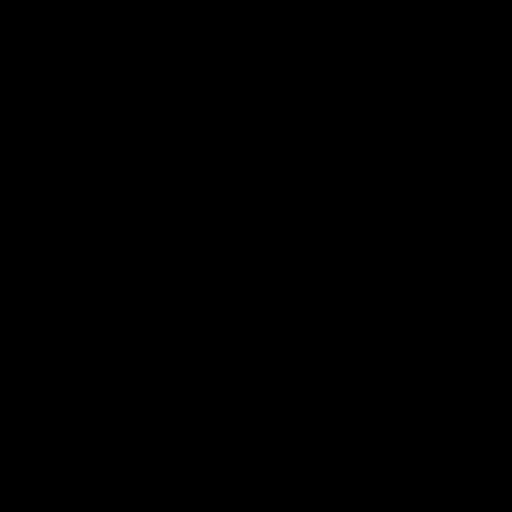
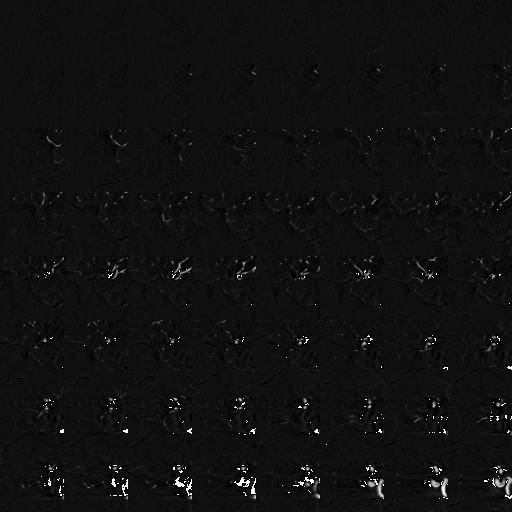

In [15]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [16]:
from comet_ml import Experiment

artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
params = {
    "batch_size": 4,
    "epochs": 40,
    "es_patience": 4, # None = deactivate early stopping
    "model_name": 'Unet3D_Oktay',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "DiceCELoss",
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "save_models":True,
    "debug": False,
    "criterion_weights": 100,
    "learning_rate": 1e-5,
    "weight_decay": None,
    "scheduler": "ReduceLROnPlateau",
    "device": "cuda:1",
    "feature_scale": 1,
}


params.update(dataset_params)
params.update(preprocessing_params)

In [ ]:
for lr in [ 1e-3]:  
    comet_exp = Experiment(
            env.cached_data["comet_key"],
            project_name=env.project + "-" + params["prediction"],
            disabled=params["debug"],
        )
    params["learning_rate"] = lr
    exp = env.create_experiment(
            params["prediction"] + "-pytorch-" + params["model_name"], comet_exp
        ) #params["selected_label"] + "-hyperopt-" + params["model_name"]
    exp.run(training.train_pytorch_model, params, artifacts)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/ea7988b5e82b4ac7b4b38405c423bde6



[INFO] Experiment mask-pytorch-Unet3D_Oktay is initialized.
[INFO] Running experiment: 2021-07-12-11-55-28_mask-pytorch-unet3d-oktay
Number of Classes 2
---Parameters Loading took 10.12515640258789 seconds ---


nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
nn.init.normal is now deprecated in favor of nn.init.normal_.
nn.init.constant is now deprecated in favor of nn.init.constant_.


Selected model: unet_3D
---Model Loading took 4.8318727016448975 seconds ---
---Dataset creation took 1.4133844375610352 seconds ---
---Data loader took 1.4147074222564697 seconds ---
---Data Loading took 1.734837532043457 seconds ---
[INFO] Train dataset loaded. Length: 1350
[INFO] Validation dataset loaded. Length: 162
[INFO] Engine run starting with max_epochs=40.


Argument save_interval is deprecated and should be None. This argument will be removed in 0.5.0.Please, use events filtering instead, e.g. Events.ITERATION_STARTED(every=1000)


[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:13:35
[INFO] Learning rate: 0.001
0.5164975314670139
[INFO] Engine run complete. Time taken: 00:13:35


## Evaluate Model

Do evaluation, e.g. visualizations  

In [ ]:
from aneurysm_utils.utils.pytorch_utils import predict

In [ ]:
model = exp.artifacts["model"]

In [ ]:
from aneurysm_utils.utils import pytorch_utils
if params['model_name'] =="SegNet":
    test_dataset = pytorch_utils.PyTorchGeometricDataset(
            mri_images=mri_imgs_test,
            labels=labels_test,
            root=env.project_folder,
            split="test",
        )
else:
    test_dataset = pytorch_utils.PytorchDataset(
                mri_imgs_test,
                labels_test,
                dtype=np.float64,
                segmentation=params.segmentation,
            )

predictions = predict(model, test_dataset, apply_softmax=False )
if params['model_name'] == "SegNet":
    pred_classes, pred_scores = extend_point_cloud(
                    predictions[0], predictions[1], test_dataset, labels_test
                )

In [ ]:
np.save(preds_out,arr = predictions)

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(pred_classes[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_test[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)